#Кластеризация текстов современных научных статей по физике с использованием эмбеддингов SciBERT и K-Means

##Анализ и подготовка данных

Импортируем основные библиотеки.

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub

Скачиваем датасет с Kaggle. Это блок кода нужно запустить несколько раз, если с первого раза датасет скачался не в ту папку.

In [178]:
path = kagglehub.dataset_download("victornuez/latest-research-articles")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'latest-research-articles' dataset.
Path to dataset files: /kaggle/input/latest-research-articles


Исследуем данные

In [179]:
df = pd.read_csv("/kaggle/input/latest-research-articles/phys_and_computsci_articles.csv")
df.head()

,title,abstract,doi,citations,accesses,online_attention,published_datetime,Topic
0,Spin Berry curvature-enhanced orbital Zeeman e...,Berry phases and the related concept of Berry ...,https://doi.org/10.1038/s41567-024-02487-z,0,353,1,22 April 2024,Physics
1,Room-temperature flexible manipulation of the ...,The quantum metric and Berry curvature are two...,https://doi.org/10.1038/s41567-024-02476-2,0,417,44,22 April 2024,Physics
2,Irreversible entropy transport enhanced by fer...,The nature of particle and entropy flow betwee...,https://doi.org/10.1038/s41567-024-02483-3,0,259,1,22 April 2024,Physics
3,Penning-trap measurement of the Q value of ele...,The investigation of the absolute scale of the...,https://doi.org/10.1038/s41567-024-02461-9,0,1733,105,19 April 2024,Physics
4,Distinct elastic properties and their origins ...,"Glasses and gels, common amorphous solids with...",https://doi.org/10.1038/s41567-024-02456-6,0,1297,14,12 April 2024,Physics


Выбираем статьи только по физике

In [180]:
df = df[df['Topic'] == 'Physics']
df.drop(columns=['Topic'], inplace=True)
df.nunique()

,0
title,2929
abstract,2918
doi,2929
citations,535
accesses,2074
online_attention,271
published_datetime,1033


Удаляем столбец doi, так как он не объясняет данные.

In [181]:
df.drop(columns=['doi'], inplace=True)

Проверяем датасет на пропуски и дубликаты

In [182]:
df.isna().sum()

,0
title,0
abstract,11
citations,0
accesses,0
online_attention,0
published_datetime,0


In [183]:
df.duplicated().sum()

np.int64(0)

Строк с пропущенными данными мало, поэтому удаляем их

In [184]:
df.dropna(inplace=True)

Получим информацию о периоде, за который приведены научные статьи.

In [185]:
df['date'] = pd.to_datetime(df['published_datetime'], format="%d %B %Y", errors='coerce')
df.dropna(inplace=True)
df['year'] = df['date'].dt.year
print(df['year'].min(), df['year'].max())

2005 2024


Преобразуем даты в номера дней, отсчитанные от дня первой доступной в датасете статьи.

In [186]:
df['time'] = (df['date'] - df['date'].min()).dt.days
df.drop(columns=['published_datetime', 'date'], inplace=True)
df.head()

,title,abstract,citations,accesses,online_attention,year,time
0,Spin Berry curvature-enhanced orbital Zeeman e...,Berry phases and the related concept of Berry ...,0,353,1,2024,6787
1,Room-temperature flexible manipulation of the ...,The quantum metric and Berry curvature are two...,0,417,44,2024,6787
2,Irreversible entropy transport enhanced by fer...,The nature of particle and entropy flow betwee...,0,259,1,2024,6787
3,Penning-trap measurement of the Q value of ele...,The investigation of the absolute scale of the...,0,1733,105,2024,6784
4,Distinct elastic properties and their origins ...,"Glasses and gels, common amorphous solids with...",0,1297,14,2024,6777


In [187]:
df['time'].nunique()

1028

Выявляем, что в столбце accesses содержатся числа в виде 10k, приводим к типу int

In [188]:
df['accesses'].describe()

,accesses
count,2917
unique,2065
top,10k
freq,107


In [189]:
df['accesses'] = df['accesses'].apply(lambda x: x.replace('k', '000'))
df['accesses'] = pd.to_numeric(df['accesses'], errors='coerce')

Данные готовы к анализу. Опишем и ислледуем их.

In [190]:
targets = ['citations', 'accesses', 'online_attention']

In [191]:
df[targets].describe()

,citations,accesses,online_attention
count,2917.000000,2917.000000,2917.000000
mean,145.295509,7167.449434,46.226603
std,229.332105,6182.894343,106.759041
min,0.000000,259.000000,0.000000
25%,33.000000,3465.000000,4.000000
50%,80.000000,5660.000000,16.000000
75%,174.000000,9050.000000,54.000000
max,5098.000000,85000.000000,3774.000000


In [192]:
df[targets].corr()

,citations,accesses,online_attention
citations,1.000000,0.592075,-0.042148
accesses,0.592075,1.000000,0.234678
online_attention,-0.042148,0.234678,1.000000


Между citations и accesses есть линейная связь средней степени силы. Разброс данных достаточно большой: стандартное отклонение порядка величины среднего значения.

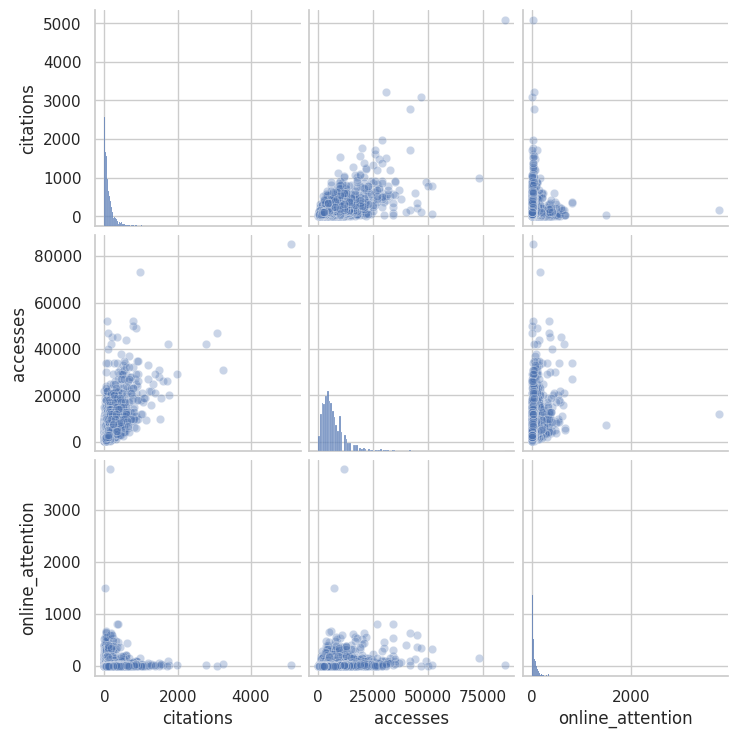

In [193]:
import seaborn as sns

sns.set(style="whitegrid")

sns.pairplot(
    df[targets],
    plot_kws={'alpha': 0.3}
)
plt.show()


Плотность точек значительно падает с удалением от нуля. Для стабильности модели исключим выбросы с использованием межквартильного размаха (IQR).

In [194]:
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


for col in targets:
    df = remove_outliers(df, col)

In [195]:
df[targets].describe()

,citations,accesses,online_attention
count,2393.000000,2393.000000,2393.000000
mean,97.457167,5576.216465,26.294609
std,87.708900,3219.854411,31.459637
min,0.000000,259.000000,0.000000
25%,29.000000,3065.000000,3.000000
50%,71.000000,5008.000000,13.000000
75%,145.000000,7477.000000,40.000000
max,385.000000,15000.000000,128.000000


Рассмотрим распределение количества статей по годам.

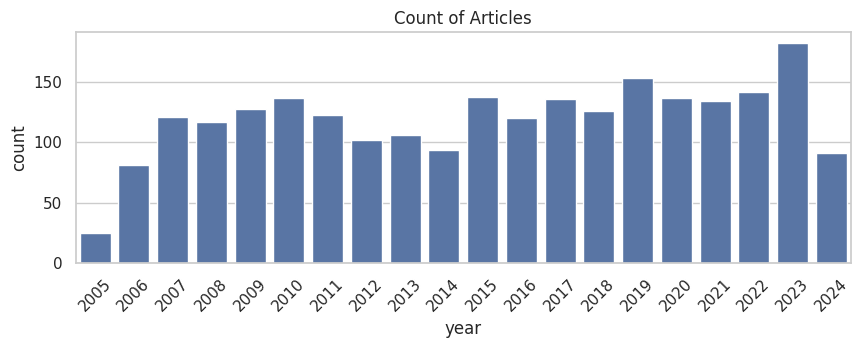

In [196]:
plt.figure(figsize=(10, 3))
sns.countplot(data=df, x='year', color='C0')
plt.xticks(rotation=45)
plt.title("Count of Articles")
plt.show()

Данные распределены по временным интервалам достаточно равномерно, за исключением 2005 года. Рассмотрим, как зависит среднее значение переменных от времени.

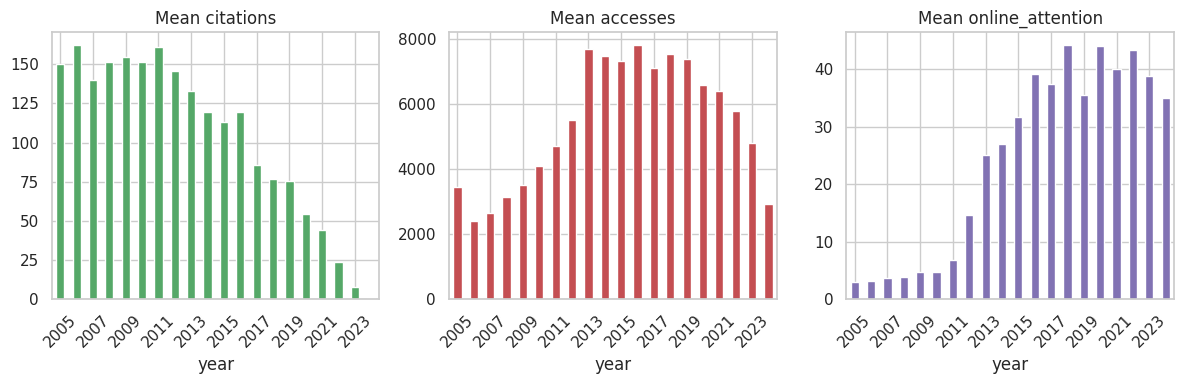

In [197]:
plt.figure(figsize=(12, 4))
for i, TARGET in enumerate(['citations', 'accesses', 'online_attention']):
    plt.subplot(1, 3, i + 1)
    year_mean = df.groupby('year')[TARGET].mean()
    year_mean.plot(kind='bar', color=f'C{i + 2}')
    plt.xticks(rotation=45)
    plt.xticks(ticks=range(0, len(year_mean), 2), labels=year_mean.index[::2])
    plt.title(f"Mean {TARGET}")

plt.tight_layout()
plt.show()

Количество цитирований в среднем линейно убывает в зависимости от времени. Чисто доступов к статьям имеет вид нормального распределения с небольшим сдвигом вправо. Онлайн-внимание явно возросло с нулевых, в течение последних 10 лет приблизительно остаётся в полосе от 50 до 70.

Исследуем текстовые данные.

In [198]:
df[['title', 'abstract']].map(len).describe()

,title,abstract
count,2393.000000,2393.000000
mean,71.848308,1377.759716
std,20.414987,205.063208
min,14.000000,632.000000
25%,57.000000,1251.000000
50%,72.000000,1373.000000
75%,85.000000,1518.000000
max,136.000000,2153.000000


Интегрируем название статьи и аннотацию в новую колонку `text`.

In [199]:
df['text'] = df['title'].astype(str) + ". " + df['abstract'].astype(str)

In [200]:
df.head()

,title,abstract,citations,accesses,online_attention,year,time,text
0,Spin Berry curvature-enhanced orbital Zeeman e...,Berry phases and the related concept of Berry ...,0,353,1,2024,6787,Spin Berry curvature-enhanced orbital Zeeman e...
1,Room-temperature flexible manipulation of the ...,The quantum metric and Berry curvature are two...,0,417,44,2024,6787,Room-temperature flexible manipulation of the ...
2,Irreversible entropy transport enhanced by fer...,The nature of particle and entropy flow betwee...,0,259,1,2024,6787,Irreversible entropy transport enhanced by fer...
3,Penning-trap measurement of the Q value of ele...,The investigation of the absolute scale of the...,0,1733,105,2024,6784,Penning-trap measurement of the Q value of ele...
4,Distinct elastic properties and their origins ...,"Glasses and gels, common amorphous solids with...",0,1297,14,2024,6777,Distinct elastic properties and their origins ...


In [201]:
df[df.isnull().any(axis=1)]

,title,abstract,citations,accesses,online_attention,year,time,text


# Моделирование

Трансформеры типа BERT хорошо улавливают семантические связи между словами в текстах. Рассмотрим границу применимости трансформера, например, даёт ли он схожие эмбеддинги для более перспективных и проработанных научных статей, то есть способен ли оценить важность текста как целого.

За целевые переменные примем все три колонки. Для учёта влияния времени применим следующую методику. Будем предсказывать не количество доступов, а отношение этой величины к среднему ожидаемому количеству. Таким образом значения, близкие к 1, будут соответствовать статьям средней степени интересности. Близкие к 0 — малоинтересные, большие 1 — наиболее примечательные. Затем стандартизируем данные.

In [202]:
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import StandardScaler
import numpy as np

targets = ['citations', 'accesses', 'online_attention']

for target in targets:
    grouped = df.groupby('time').agg({target: 'mean'}).reset_index()
    x = grouped['time'].values
    y = grouped[target].values
    spline = UnivariateSpline(x, y, s=1e8)
    grouped[f'{target}_spline_pred'] = spline(x)
    min_pred = np.nanpercentile(np.abs(grouped[f'{target}_spline_pred'].values), 1)
    min_pred = max(min_pred, 1e-6)
    grouped[f'{target}_spline_pred'] = grouped[f'{target}_spline_pred'].clip(lower=min_pred)
    df = df.merge(grouped[['time', f'{target}_spline_pred']], on='time', how='left')
    df[f'{target}_ratio'] = df[target] / df[f'{target}_spline_pred']

ratio_cols = [f'{t}_ratio' for t in targets]
fill_vals = df[ratio_cols].median()
scaler = StandardScaler()
z_cols = [f'{c}_z' for c in ratio_cols]
z_values = scaler.fit_transform(df[ratio_cols].fillna(fill_vals))
print('max abs z before clip:', np.nanmax(np.abs(z_values)))

threshold = 2
df[z_cols] = np.clip(z_values, -threshold, threshold)
print('max abs z after clip:', df[z_cols].abs().max().max())


max abs z before clip: 17.56785033060759
max abs z after clip: 2.0


In [203]:
df.describe()

,citations,accesses,online_attention,year,time,citations_spline_pred,citations_ratio,accesses_spline_pred,accesses_ratio,online_attention_spline_pred,online_attention_ratio,citations_ratio_z,accesses_ratio_z,online_attention_ratio_z
count,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000,2393.000000
mean,97.457167,5576.216465,26.294609,2015.341412,3685.159632,98.619337,1.023574,5579.675748,0.999344,26.977148,0.969561,-0.042496,-0.028373,-0.046728
std,87.708900,3219.854411,31.459637,5.492777,1989.544928,53.155619,0.958761,2472.857078,0.396693,15.599564,1.314417,0.711597,0.910489,0.723438
min,0.000000,259.000000,0.000000,2005.000000,7.000000,0.447843,0.000000,1348.020864,0.122006,2.506866,0.000000,-1.067825,-2.000000,-0.737790
25%,29.000000,3065.000000,3.000000,2010.000000,1900.000000,54.384242,0.453456,3604.026038,0.726577,10.128765,0.124308,-0.594766,-0.687745,-0.643198
50%,71.000000,5008.000000,13.000000,2016.000000,3819.000000,111.907644,0.815076,5445.010475,0.986767,33.491955,0.582337,-0.217512,-0.031711,-0.294659
75%,145.000000,7477.000000,40.000000,2020.000000,5401.000000,151.148499,1.362409,7251.292837,1.218547,41.305346,1.393531,0.353482,0.552691,0.322621
max,385.000000,15000.000000,128.000000,2024.000000,6787.000000,156.866491,17.863421,14999.913498,4.125225,44.533025,19.756049,2.000000,2.000000,2.000000


Построим график зависимости `accesses` от времени, по оси абсцисс отложим номера дней. Проведём кривую, аппроксимирующие зашумлённую зависимость.

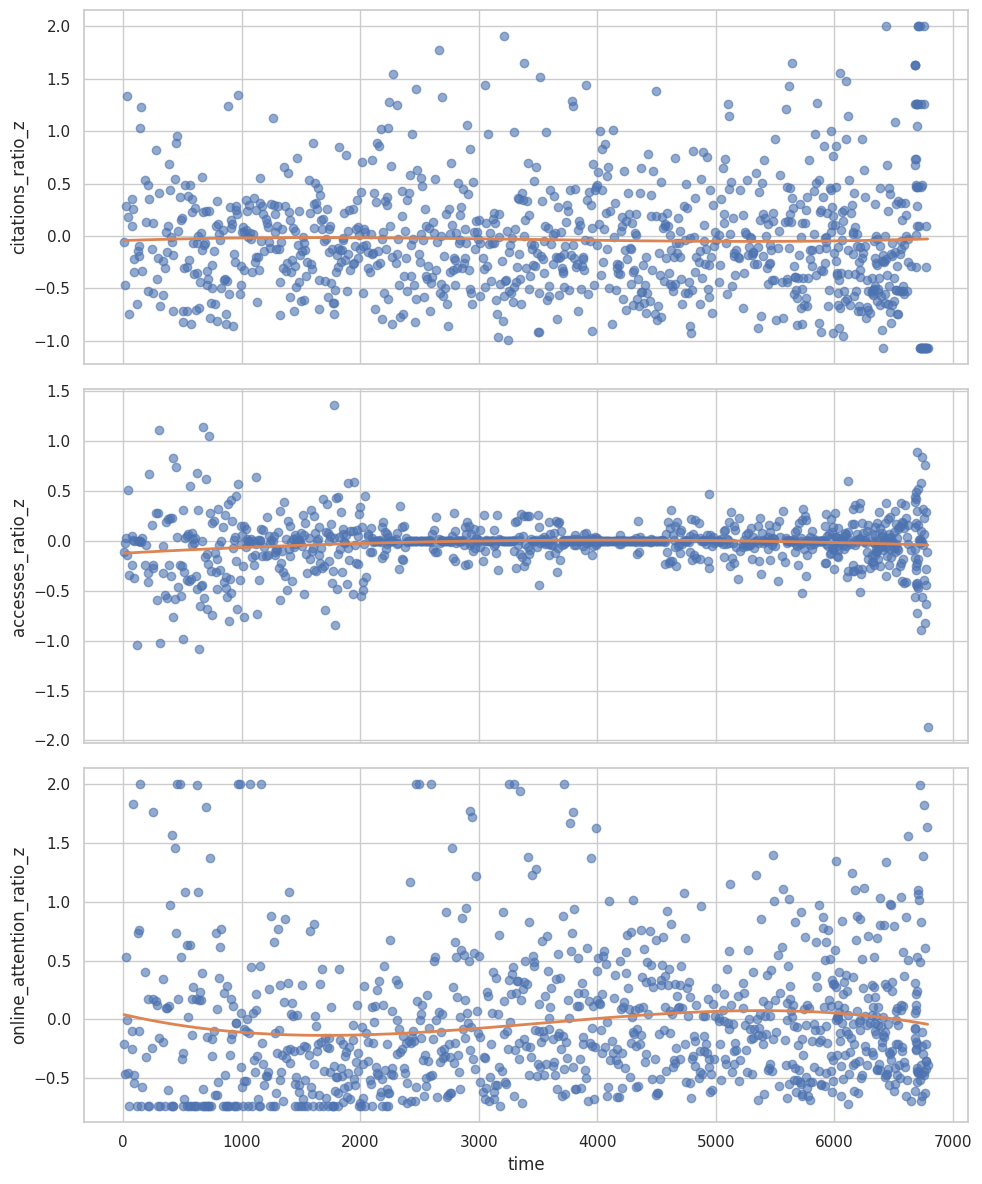

In [204]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

for ax, target in zip(axes, [f'{c}_z' for c in ratio_cols]):
    grouped = df.groupby('time').agg({target: 'mean'}).reset_index()
    x = grouped['time'].values
    y = grouped[target].values
    spline = UnivariateSpline(x, y, s=1e8)
    smooth_vals = spline(x)
    ax.plot(x, y, 'o', alpha=0.6)
    ax.plot(x, smooth_vals, '-', linewidth=2)
    ax.set_ylabel(target)
    ax.grid(True)
axes[-1].set_xlabel("time")
plt.tight_layout()
plt.show()


##Токенизация и моделирование

Установим основные библиотеки для работы с трансформерами

In [205]:
!pip install -q transformers datasets tqdm

Импортируем основные библиотеки, выставим seed. Инициализируем SciBERT для извлечения эмбеддингов из текстов без дообучения. SciBERT — трансформер, обученный на научных текстах (компьютерные науки и медицина). У модели около 110 млн параметров, как и у оригинального BERT.

In [206]:
import torch
from transformers import AutoTokenizer, AutoModel

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(seed)
else:
    device = torch.device("cpu")
print("Device:", device)

model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sci_model = AutoModel.from_pretrained(model_name)
sci_model.to(device)
sci_model.eval()

Device: cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Функция для получения эмбеддингов для списка текстов. Будем использовать `mean_pooling` с учётом масок, разбиваем данные на батчи. Контролируем процесс с `tqdm`.

In [207]:
from tqdm import tqdm

def encode_texts(texts, tokenizer, model, device, batch_size=16, max_len=400):
    embeddings = []
    n = len(texts)

    for i in tqdm(range(0, n, batch_size), desc="Extracting embeddings", unit="batch"):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, padding='longest', truncation=True, max_length=max_len, return_tensors='pt')
        input_ids = enc['input_ids'].to(device)
        attention_mask = enc['attention_mask'].to(device)

        with torch.no_grad():
            out = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
            last_hidden = out.last_hidden_state
            mask = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            # applying the mask
            summed = torch.sum(last_hidden * mask, 1)
            # counting important tokens
            counts = torch.clamp(torch.sum(mask, 1), min=1e-9)
            pooled = (summed / counts).cpu().numpy()
            embeddings.append(pooled)

    embeddings = np.vstack(embeddings)
    return embeddings

Получим эмбеддинги для всех статей. Для каждого текста выходит 768 чисел.

In [169]:
texts_all = df['text'].tolist()
embeddings = encode_texts(texts_all, tokenizer, sci_model, device, batch_size=16, max_len=400)
embeddings.shape

Extracting embeddings: 100%|██████████| 150/150 [00:59<00:00,  2.54batch/s]


(2393, 768)

Проведём нормализацию эмбеддингов. Уменьшеним размерность через PCA. Оставим направления, достаточные для объяснения $95\%$ дисперсии. Хватает около 200 компонент, что много, но терпимо для работы с текстами

In [170]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA


emb_norm = normalize(embeddings)
pca = PCA(n_components=None, random_state=seed)
pca.fit(emb_norm)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance >= 0.95) + 1

pca = PCA(n_components=n_components, random_state=seed)
emb_pca = pca.fit_transform(emb_norm)

print(f"Using {n_components} components")

Using 220 components


Разобьем данные на кластеры через K-Means и добавим полученные метки. Работаем с текстами, поэтому расстояние косинусное. Количество кластеров находим, вычисляя коэффициент силуэта на сетке. Максимум приходится на 3. Разбиение на 4 кластера разделяет один из кластеров на 2.

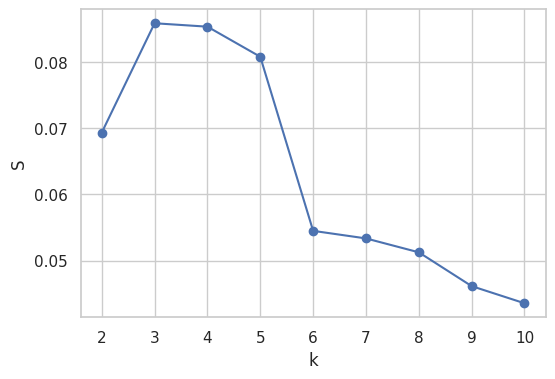

In [171]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


sil_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(emb_pca)
    sil = silhouette_score(emb_pca, labels)
    sil_scores.append(sil)

plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("S")
plt.grid(True)
plt.show()


Делаем предикт, выводим данные о центроидах кластеров.

In [209]:
km = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = km.fit_predict(emb_pca)

df['cluster'] = labels
unique, counts = np.unique(labels, return_counts=True)
print("Clusters found:", dict(zip(unique.tolist(), counts.tolist())))

Clusters found: {0: 918, 1: 548, 2: 927}


Визуализируем результат через две главные компонентны PCA. Занесём координаты точек на плоскости в `df`.

In [210]:
from sklearn.manifold import TSNE

pca2 = PCA(n_components=2, random_state=seed)
coords_pca2 = pca2.fit_transform(emb_norm)

df['x'] = coords_pca2[:, 0]
df['y'] = coords_pca2[:, 1]

График с PCA.

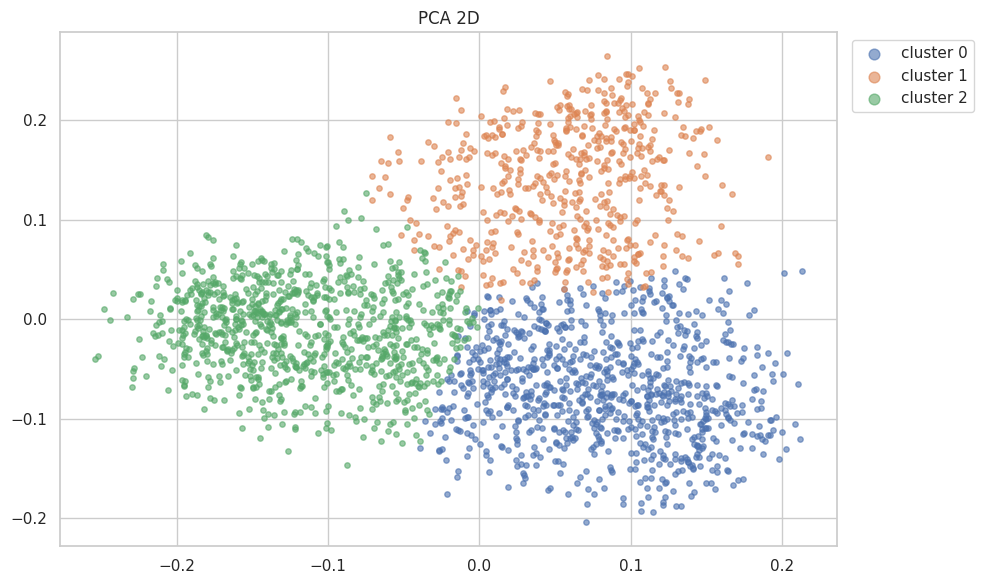

In [211]:
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
clusters = sorted(df['cluster'].unique())
palette = sns.color_palette(n_colors=len(clusters))

for i, c in enumerate(clusters):
    subset = df[df['cluster'] == c]
    plt.scatter(subset['x'], subset['y'], s=15, alpha=0.6, label=f'cluster {c}')

plt.title("PCA 2D")
plt.legend(markerscale=2, bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


График t-SNE.

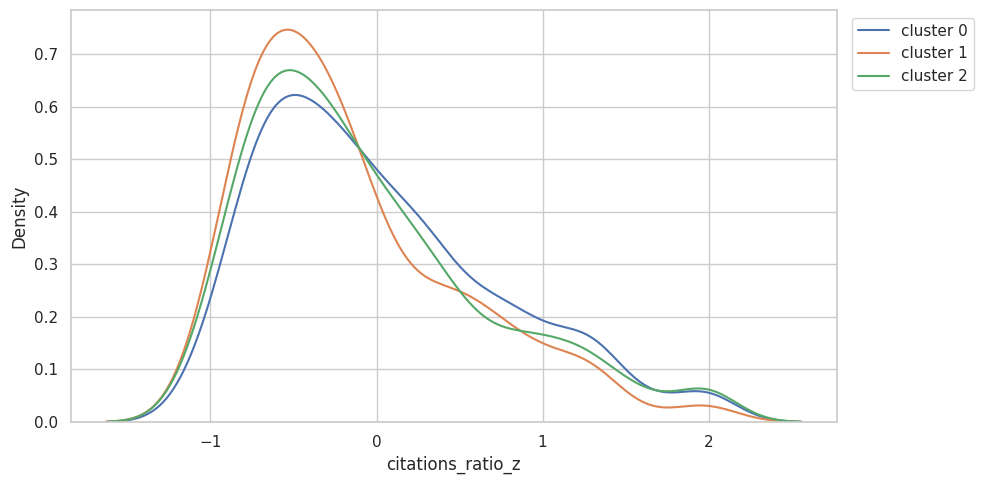

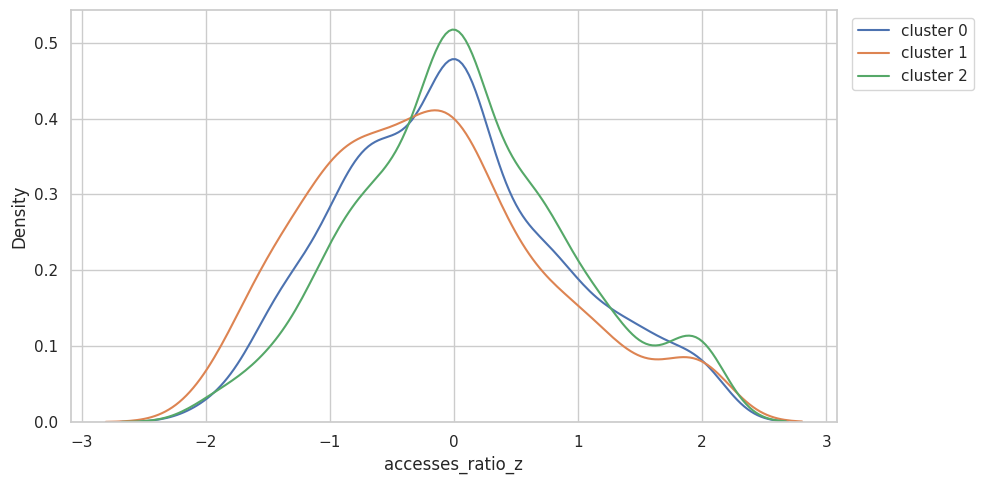

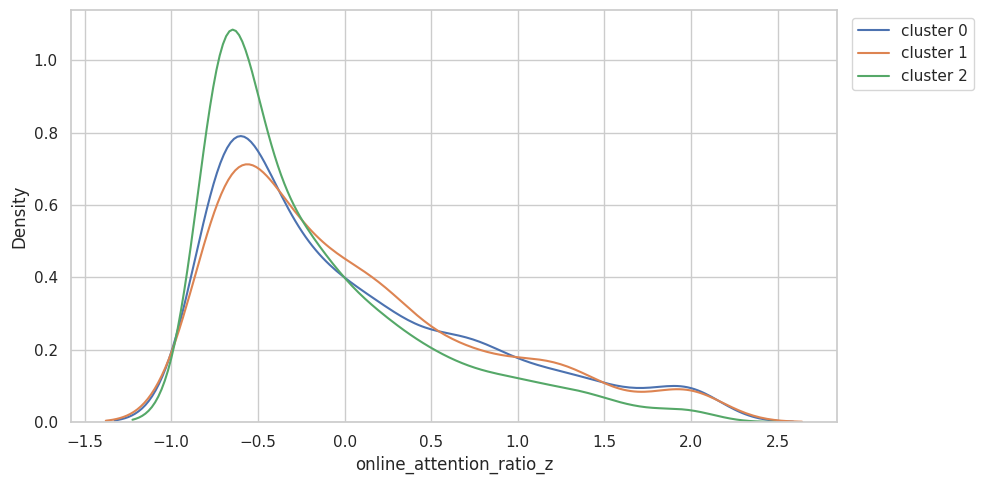

In [213]:
plot_targets = z_cols

clusters_to_plot = list(sorted(df['cluster'].unique()))

for target in plot_targets:
    plt.figure(figsize=(10, 5))
    for c in clusters_to_plot:
        subset = df[df['cluster'] == c]
        if len(subset) > 1:
            label = f'cluster {c}' if c != -1 else 'outliers (-1)'
            sns.kdeplot(subset[target].dropna(), label=label, common_norm=False)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Вывод размеров кластеров и простая статистика по целевым переменным в кластерах.

In [176]:
std_ratio_cols = [f'{c}_z' for c in ratio_cols]
cluster_stats = df.groupby('cluster')[std_ratio_cols].agg(['count', 'mean', 'std'])
cluster_stats


citations_ratio_z                     accesses_ratio_z            \
                    count      mean       std            count      mean   
cluster                                                                    
0                     446 -0.127141  0.724710              446 -0.070095   
1                     534  0.126733  0.911698              534  0.097561   
2                     495 -0.069540  0.715792              495 -0.250158   
3                     918 -0.020539  0.829036              918  0.108335   

                  online_attention_ratio_z                      
              std                    count      mean       std  
cluster                                                         
0        1.029792                      446  0.062621  0.910495  
1        0.888064                      534  0.065435  0.861291  
2        1.030363                      495  0.105269  0.964120  
3        0.981338                      918 -0.171507  0.685581

Графики показывают, что итоговое разбиение на кластеры не связано с метриками ранговости научных статей. Деление, должно быть, связано с тематической общностью отдельных экземпляров набора данных, что и указывает на ограниченность трансформеров типа BERT извлечением семантических свойств, но не глубины текста.